<a href="https://colab.research.google.com/github/Dharma-Ranganathan/AllAboutPython/blob/main/ML_Projects_Codes/BigMartSalesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Big Mart Sales Prediction**

Dependencies

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

Data collection

In [91]:
big_mart = pd.read_csv('/content/drive/MyDrive/Colab_python/big_mart_data.csv')

# check
big_mart.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Data Analysis and Pre-processing

In [92]:
# check information
big_mart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


* seems null values exists

In [93]:
# check null
big_mart.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


* seems item weight and outlet size has null values

In [94]:
# item weight check
print('mean of item weight : ')
item_weight_mean = big_mart['Item_Weight'].mean()
print(item_weight_mean)

mean of item weight : 
12.857645184135976


In [95]:
# filling mean to item weight
big_mart['Item_Weight'].fillna(item_weight_mean, inplace=True)

/tmp/ipython-input-3934225183.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  big_mart['Item_Weight'].fillna(item_weight_mean, inplace=True)


In [96]:
# check null in item weight
big_mart.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


* still have outlet size to fill na, but those are categorical data
* Outlet size depends on outlet type , using pivot table , we fill na in outlet size

In [97]:
# mode using pivot table
modes = big_mart.pivot_table(values='Outlet_Size',columns='Outlet_Type',aggfunc=(lambda x : x.mode()[0]) )

modes['Grocery Store']

,Grocery Store
Outlet_Size,Small


* why mode, cause mean and median meant for regression only but mode can be used both in regression and classification
* Mode value for each outlet type differs in pivot table

In [98]:
missed = big_mart['Outlet_Size'].isnull()

missed

,Outlet_Size
0,False
1,False
2,False
3,True
4,False
...,...
8518,False
8519,True
8520,False
8521,False


In [99]:
# checking outlet size - missed location

print(big_mart.loc[missed,'Outlet_Size'])
print()
print('total null counts :')
print((big_mart.loc[missed,'Outlet_Size'].value_counts()))

3       NaN
8       NaN
9       NaN
25      NaN
28      NaN
       ... 
8502    NaN
8508    NaN
8509    NaN
8514    NaN
8519    NaN
Name: Outlet_Size, Length: 2410, dtype: object

total null counts :
Series([], Name: count, dtype: int64)


In [100]:
# checking relevant outlet type - missed location
print(big_mart.loc[missed,'Outlet_Type'])
print()
print("total counts of relevant: ")
print((big_mart.loc[missed,'Outlet_Type'].value_counts()))

3           Grocery Store
8       Supermarket Type1
9       Supermarket Type1
25      Supermarket Type1
28          Grocery Store
              ...        
8502    Supermarket Type1
8508    Supermarket Type1
8509        Grocery Store
8514    Supermarket Type1
8519    Supermarket Type1
Name: Outlet_Type, Length: 2410, dtype: object

total counts of relevant: 
Outlet_Type
Supermarket Type1    1855
Grocery Store         555
Name: count, dtype: int64


In [101]:
big_mart.loc[missed,'Outlet_Size'] = big_mart.loc[missed,'Outlet_Type'].apply(lambda x : modes[x])

# check
big_mart[['Outlet_Size','Outlet_Type']]

,Outlet_Size,Outlet_Type
0,Medium,Supermarket Type1
1,Medium,Supermarket Type2
2,Medium,Supermarket Type1
3,Small,Grocery Store
4,High,Supermarket Type1
...,...,...
8518,High,Supermarket Type1
8519,Small,Supermarket Type1
8520,Small,Supermarket Type1
8521,Medium,Supermarket Type2


Dropping item and outlet identifier

In [102]:
big_mart.drop(['Item_Identifier','Outlet_Identifier'], axis=1,inplace=True)

Data Visualization

In [105]:
big_mart.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,Small,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


In [106]:
# numerical description
big_mart.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


* distribution of numerical datas

In [107]:
sns.set()

* distribution of item weight - proper skewed

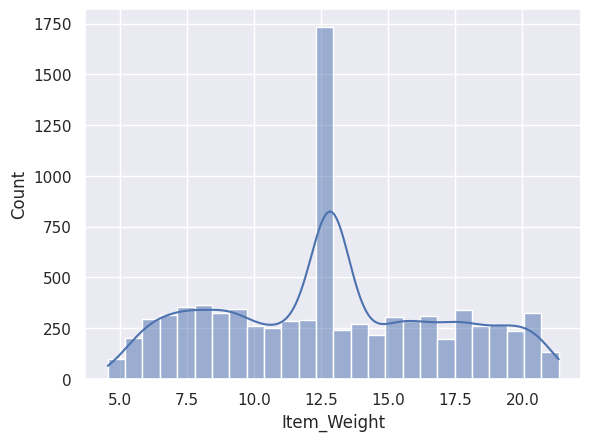

In [112]:
sns.histplot(big_mart['Item_Weight'],kde=True)
plt.show()

* distribution of item visibility - positive left skewed

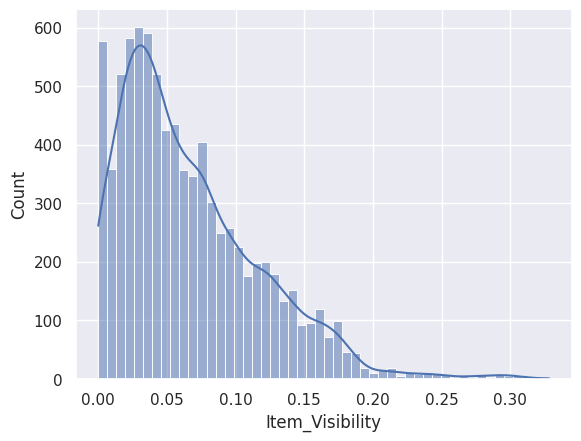

In [113]:
sns.histplot(big_mart['Item_Visibility'],kde=True)
plt.show()

* distribution of item price - random skewness - more like fluctuated

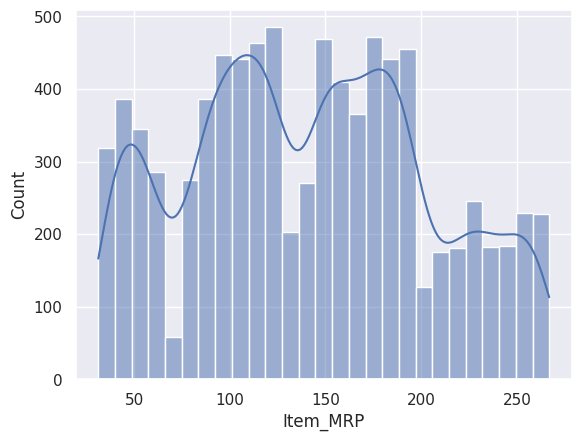

In [114]:

sns.histplot(big_mart['Item_MRP'],kde=True)
plt.show()

* counts of outlet established year

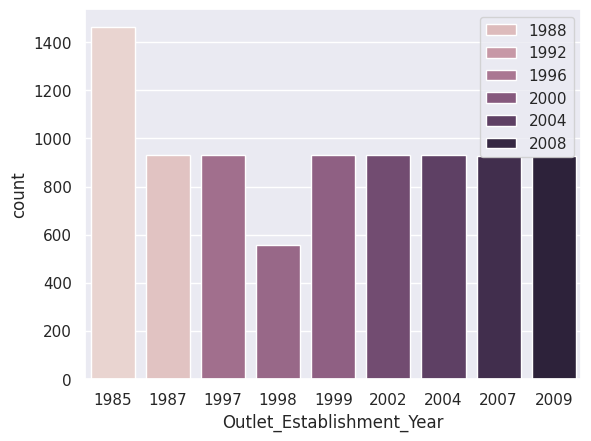

In [127]:
sns.countplot(x='Outlet_Establishment_Year',data = big_mart,hue='Outlet_Establishment_Year')
plt.legend()
plt.show()

* distribution of item sales - positive left skewed

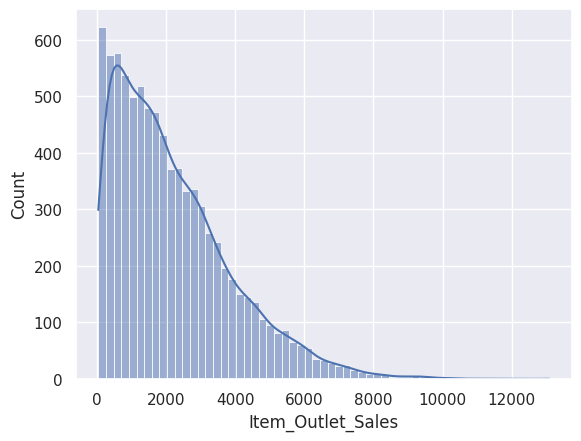

In [116]:

sns.histplot(big_mart['Item_Outlet_Sales'],kde=True)
plt.show()

* counts of item fat count

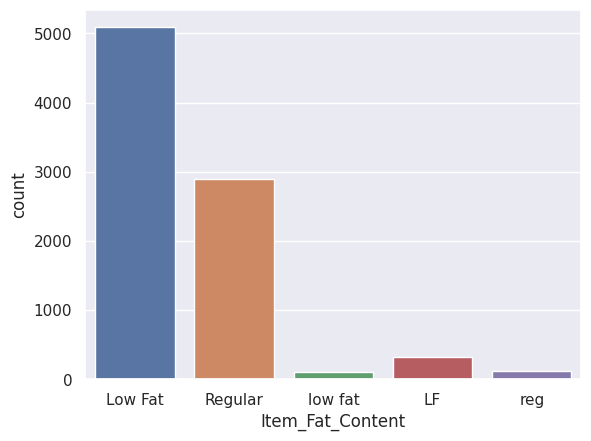

In [130]:
sns.countplot(x='Item_Fat_Content',data=big_mart,hue='Item_Fat_Content')
plt.show()

* may notice, differed in low fat and regular , we need to join it

In [134]:
big_mart.replace({
    'Item_Fat_Content':{
        'low fat' : 'Low Fat',
        'LF' : 'Low Fat',
        'reg':'Regular'
    }
}, inplace=True)

# check
big_mart['Item_Fat_Content']

,Item_Fat_Content
0,Low Fat
1,Regular
2,Low Fat
3,Regular
4,Low Fat
...,...
8518,Low Fat
8519,Regular
8520,Low Fat
8521,Regular


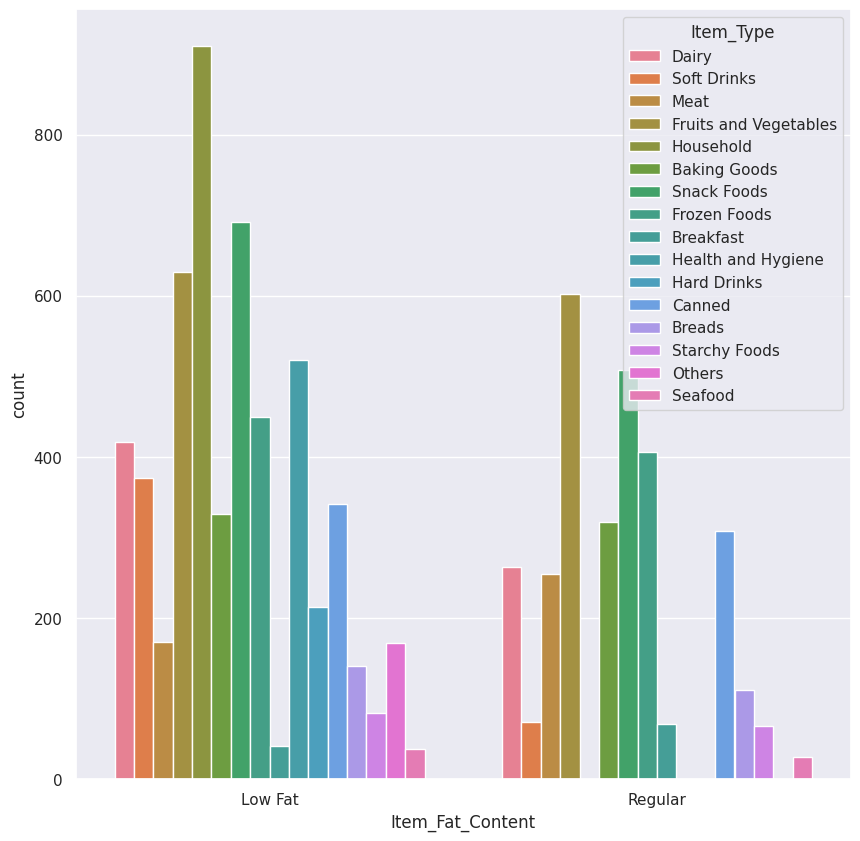

In [143]:
plt.figure(figsize=(10,10))
sns.countplot(x='Item_Fat_Content',data=big_mart,hue='Item_Type')
plt.show()

* counts of outlet size

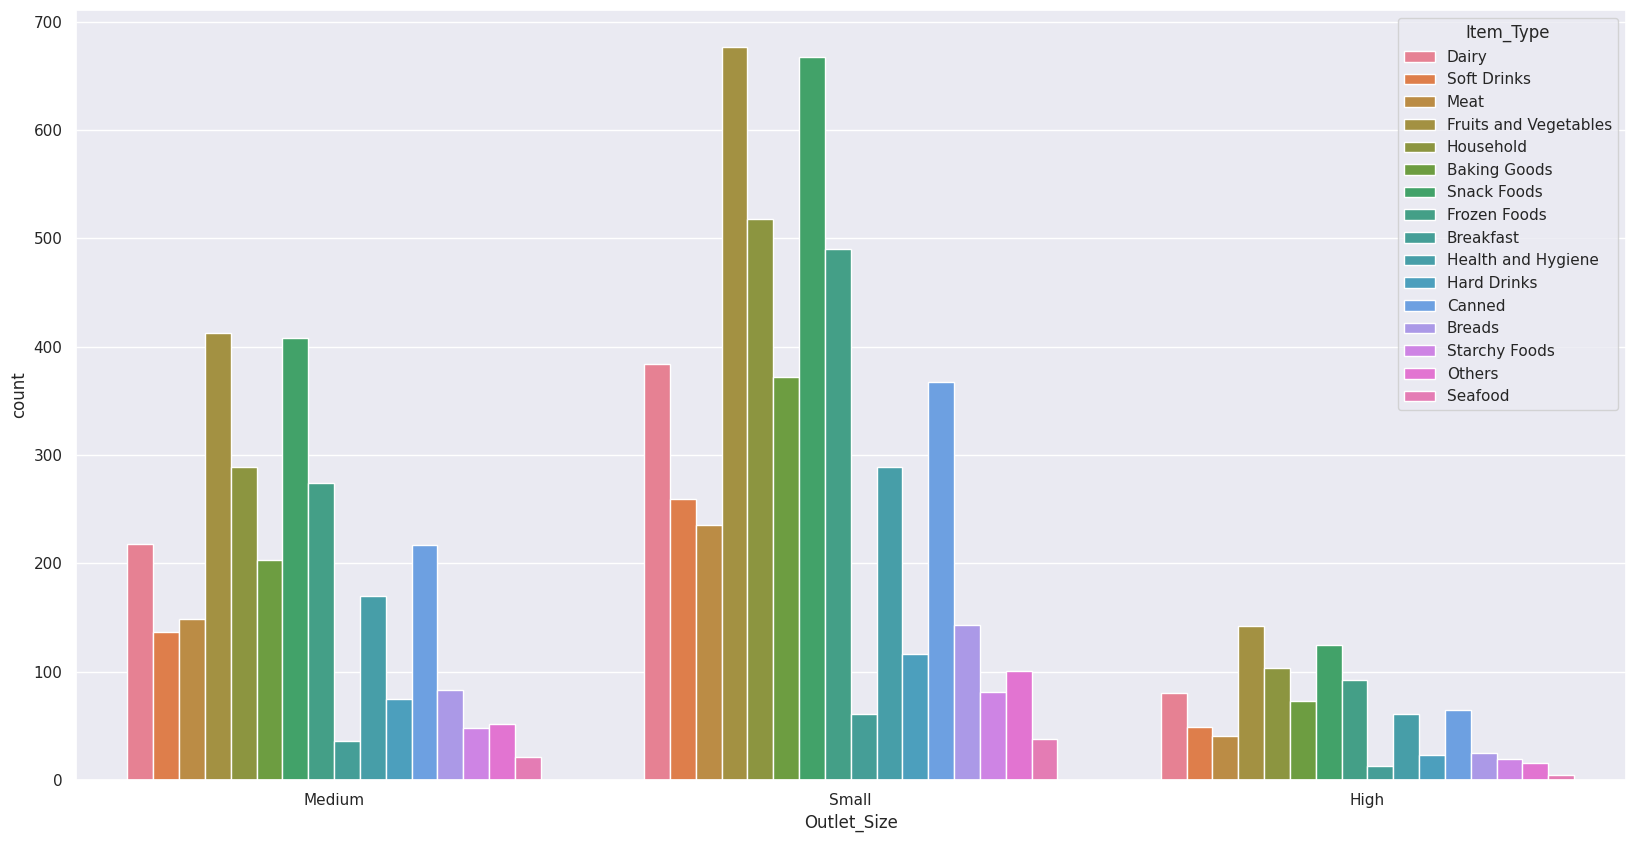

In [147]:
plt.figure(figsize=(20,10))
sns.countplot(x='Outlet_Size',data=big_mart,hue='Item_Type')
plt.show()

* shape

In [148]:
big_mart.shape

(8523, 10)

Categorical features :

* Item_Fat_Content
* Item_Type
* Outlet_Size
* Outlet_Location_Type
* Outlet_Type

**Label Encoding**

In [150]:
# label encoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# encoding

big_mart['Item_Fat_Content'] = encoder.fit_transform(big_mart['Item_Fat_Content'])

big_mart['Item_Type'] = encoder.fit_transform(big_mart['Item_Type'])

big_mart['Outlet_Size'] = encoder.fit_transform(big_mart['Outlet_Size'])

big_mart['Outlet_Location_Type'] = encoder.fit_transform(big_mart['Outlet_Location_Type'])

big_mart['Outlet_Type'] = encoder.fit_transform(big_mart['Outlet_Type'])

# check
big_mart.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,0,0.016047,4,249.8092,1999,1,0,1,3735.1380
1,5.92,1,0.019278,14,48.2692,2009,1,2,2,443.4228
2,17.50,0,0.016760,10,141.6180,1999,1,0,1,2097.2700
3,19.20,1,0.000000,6,182.0950,1998,2,2,0,732.3800
4,8.93,0,0.000000,9,53.8614,1987,0,2,1,994.7052


In [152]:
big_mart.shape

(8523, 10)

**Splitting features and label**

In [154]:
features = big_mart.drop('Item_Outlet_Sales',axis=1)
label = big_mart['Item_Outlet_Sales']

features.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.30,0,0.016047,4,249.8092,1999,1,0,1
1,5.92,1,0.019278,14,48.2692,2009,1,2,2
2,17.50,0,0.016760,10,141.6180,1999,1,0,1
3,19.20,1,0.000000,6,182.0950,1998,2,2,0
4,8.93,0,0.000000,9,53.8614,1987,0,2,1


In [155]:
label.head()

,Item_Outlet_Sales
0,3735.1380
1,443.4228
2,2097.2700
3,732.3800
4,994.7052


**Training and Testing**

In [166]:

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(features,label,test_size=0.2,random_state=42)

# check
print(features.shape,x_train.shape,x_test.shape)

(8523, 9) (6818, 9) (1705, 9)


**Model Selection**

In [219]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3,0.5],
    'max_depth': [3, 5, 7,10],
    'n_estimators': [50, 100, 200,500]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5)
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.5979137760178131


In [220]:
model = XGBRegressor(n_estimators = 500, learning_rate=0.01,max_depth=3)

In [ ]:
# fitting training dataset
model.fit(x_train,y_train)

**Model Evaluation**

In [223]:

# prediction of seen data

train_pred = model.predict(x_train)

# r square score - more like accuracy score in classification model

train_r2 = r2_score(train_pred,y_train)

train_r2 = train_r2 * 100

train_r2 = round(train_r2,2)

print(f'R squared score of seen data : {train_r2}%')

R squared score of seen data : 31.1%


In [216]:
# mean squared error - loss function

train_mse = mean_squared_error(train_pred,y_train)

print(f'mean square error (LF) : {train_mse}')

mean square error (LF) : 1144314.3609751821


In [224]:
# prediction of unseen data

test_pred = model.predict(x_test)

# r square score

test_r2 = r2_score(test_pred,y_test)

test_r2 = test_r2 * 100

test_r2 = round(test_r2,2)

print(f'R square score of unseen data : {test_r2}%')

R square score of unseen data : 35.23%


In [225]:
test_mse = mean_squared_error(test_pred,y_test)

print(f'mean squared error (LF) : {test_mse}')

mean squared error (LF) : 1047551.1606794678


Thank you...